In [1]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import os
import random
import torch
import torchvision.transforms as transforms
import torchvision

In [2]:
DATA_ROOT = "../data"

In [3]:
test_root = os.path.join(DATA_ROOT, "raw\Test")
train_root = os.path.join(DATA_ROOT, "raw\Train")
classes = [] 

In [4]:
paths = ["1_AP.jpg", "2_Lateral.jpg", "3_Lateral.jpg"]
classes = [p.split("_")[1].split(".")[0] for p in paths]

print(classes)
print(set(classes))
classes = set(classes)

['AP', 'Lateral', 'Lateral']
{'AP', 'Lateral'}


In [5]:
ind_to_class = {ind:cl for ind,cl in enumerate(classes) }
ind_to_class

{0: 'AP', 1: 'Lateral'}

In [6]:
class_to_ind = {value: key for key, value in ind_to_class.items()}
class_to_ind

{'AP': 0, 'Lateral': 1}

In [7]:
class ImageClassificationDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform # TODO 
        self.image_paths = os.listdir(root)
        self.classes = [p.split("_")[1].split(".")[0] for p in self.image_paths]
        self.classes_unique = set(self.classes)
        self.ind_to_class = {ind:cl for ind,cl in enumerate(self.classes_unique)}
        self.class_to_ind = {value:key for key, value in self.ind_to_class.items()}
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        full_image_path = os.path.join(self.root, image_path)
        label_name = image_path.split("_")[1].split(".")[0] # OR: label = self.classes[index]
        label = self.class_to_ind[label_name]
        img = Image.open(full_image_path).convert(mode = "RGB") #OR: .convert(mode = "L") because greyscale (but then transform need to match)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [8]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [10]:
full_train_dataset = ImageClassificationDataset(train_root, transform=transform)
test_dataset = ImageClassificationDataset(test_root, transform=transform)

print(f'Train: {len(full_train_dataset)}')
print(f'Test: {len(test_dataset)}')

Train: 190
Test: 27


Text(0.5, 1.0, 'Test set')

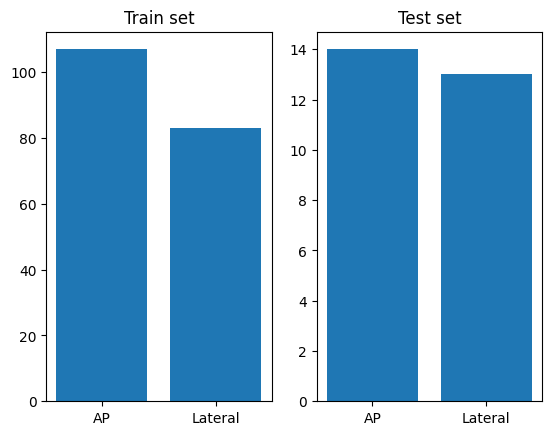

In [14]:
# Check class balance
import matplotlib.pyplot as plt
train_labels = full_train_dataset.classes
test_labels = test_dataset.classes

keys, counts = np.unique(train_labels, return_counts=True)
keys_test, counts_test = np.unique(test_labels, return_counts=True)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(keys, counts)
ax2.bar(keys_test, counts_test)
ax1.set_title("Train set")
ax2.set_title("Test set")

In [12]:
# Obtain a validation set from the full traiing set - OPTIONAL

# Idea 1  - use random test split, ISSUE - won't ensure that the classes are balanced
# train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [0.8, 0.2])

# Idea 2 - use dta split from sklearn, can take classes into account
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

train_ind, val_ind = train_test_split(
    range(len(full_train_dataset)), 
    stratify=full_train_dataset.classes,
    test_size=0.2,
    random_state=1)

train_dataset = Subset(full_train_dataset, train_ind)
val_dataset = Subset(full_train_dataset, val_ind)

print(len(train_dataset))
print(len(val_dataset))

152
38


In [13]:
sample_im = val_dataset[random.randint(0, len(val_dataset))]
display(sample_im[0], sample_im[1])

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

1

In [14]:
###------------FIRST OBSERVATIONS------------###
# black artifacts on both sides of the image - could be removed, BUT: some images positioned somehow diogonally
# ideally would be to orient the images the same way first
# symmetry of AP images as compared to Lateral

In [28]:
import matplotlib.pyplot as plt

In [29]:
def imshow(img):
    print(type(img))
    img = img / 2 + 0.5 #if denormalization is needed
    npimg = np.array(img)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

<class 'torch.Tensor'>


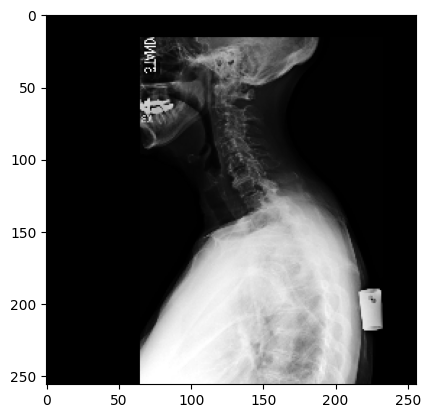

In [17]:
imshow(val_dataset[0][0])

In [18]:
# Dataloaders
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

<class 'torch.Tensor'>


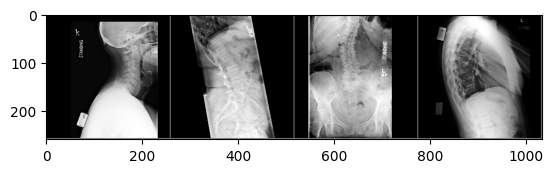

Lateral AP AP Lateral


In [27]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
labels = labels.tolist()
l = labels[0]
# print(l, type(l))
# print(labels, ind_to_class[labels[0]])
imshow(torchvision.utils.make_grid(images))
print(" ".join(f'{ind_to_class[labels[j]]}' for j in range(batch_size)))

In [23]:
# OBSERVATION 2 - some labels are wrong - fixed
#
# TRAIN:
# 010_Lateral -> AP
# 027_Lateral -> AP
# 075_Lateral -> AP
# 089_AP -> Lateral
# 113_AP -> Lateral
# 126_AP -> Lateral
#
#TEST
# 197_Lateral -> AP
# 217_AP -> Lateral


In [15]:
test_root_corrected = os.path.join(DATA_ROOT, "processed/raw_corrected\Test")
train_root_corrected = os.path.join(DATA_ROOT, "processed/raw_corrected\Train")
full_train_dataset_corrected = ImageClassificationDataset(train_root_corrected, transform=transform)
test_dataset_corrected = ImageClassificationDataset(test_root_corrected, transform=transform)

print(f'Train: {len(full_train_dataset_corrected)}')
print(f'Test: {len(test_dataset_corrected)}')

Train: 190
Test: 27


Text(0.5, 1.0, 'Test set')

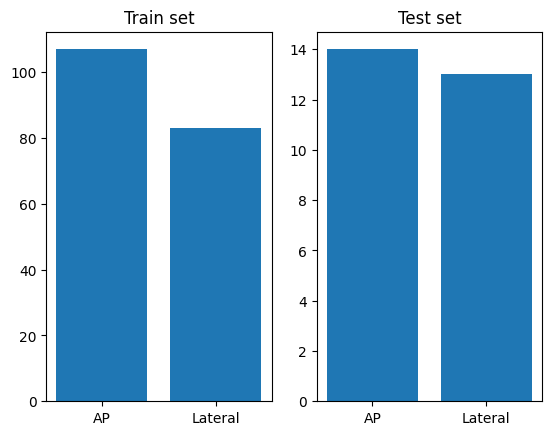

In [16]:
# Check class balance
import matplotlib.pyplot as plt
train_labels = full_train_dataset_corrected.classes
test_labels = test_dataset_corrected.classes

keys, counts = np.unique(train_labels, return_counts=True)
keys_test, counts_test = np.unique(test_labels, return_counts=True)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(keys, counts)
ax2.bar(keys_test, counts_test)
ax1.set_title("Train set")
ax2.set_title("Test set")

## Preprocessing


In [57]:
%%capture
!pip install kornia
!pip install kornia-rs

In [58]:
import kornia as K
from torch.nn import Module
from torch import Tensor
from typing import Tuple
from kornia.enhance import equalize_clahe


class EqualizeClahe(Module):
    def __init__(self, 
                clip_limit: float = 40.0,
                grid_size: Tuple[int, int] = (8, 8),
                slow_and_differentiable: bool = False
                 ) -> None:
        super().__init__()
        self.clip_limit = clip_limit
        self.grid_size = grid_size
        self.slow_and_differentiable = slow_and_differentiable

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}"
            f"(clip_limit={self.clip_limit}, "
            f"grid_size={self.grid_size}, "
            f"slow_and_differentiable={self.slow_and_differentiable})"
        )

    def forward(self, input: Tensor) -> Tensor:
        # ref: https://kornia.readthedocs.io/en/latest/_modules/kornia/enhance/equalization.html#equalize_clahe
        return equalize_clahe(input, self.clip_limit, self.grid_size, self.slow_and_differentiable)

In [77]:
sample = full_train_dataset[0][0]
type(sample)
sample = sample.unsqueeze(0)
sample.size()


torch.Size([1, 3, 256, 256])

In [112]:
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm

class HistogramNormalize:
    """Performs histogram normalization on numpy array and returns 8-bit image.

    Code was taken from lightly, but adpated to work with PIL image as input:
    https://docs.lightly.ai/self-supervised-learning/tutorials/package/tutorial_custom_augmentations.html
    who adapted it from Facebook:
    https://github.com/facebookresearch/CovidPrognosis

    """

    def __init__(self, number_bins: int = 256):
        self.number_bins = number_bins

    def __call__(self, image: np.array) -> Image:
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        # Get the image histogram.
        image_histogram, bins = np.histogram(
            image.flatten(), self.number_bins, density=True
        )
        cdf = image_histogram.cumsum()  # cumulative distribution function
        cdf = 255 * cdf / cdf[-1]  # normalize

        # Use linear interpolation of cdf to find new pixel values.
        image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
        pil_image = Image.fromarray(np.uint8(image_equalized.reshape(image.shape)))
        # return Image.fromarray(image_equalized.reshape(image.shape))
        return pil_image


def preprocess_dataset(image_folder, processed_image_folder):
    if not os.path.exists(processed_image_folder):
        os.makedirs(processed_image_folder)

    images = sorted(os.listdir(image_folder))
    histN = HistogramNormalize()

    print(histN)

    for im_name in tqdm(images):
        print(f'image {im_name}')
        # # read file
        # im_file = os.path.join(image_folder, im_name)
        # img = Image.open(im_file).convert(mode = "L")
        # np_img = np.array(img)
        
        # # process
        # processed = histN(np_img) 

        # # save
        # new_im_file = os.path.join(processed_image_folder, im_name)
        
        # processed.save(str(new_im_file))

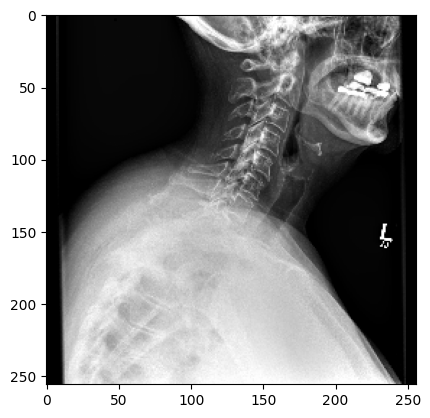

In [129]:
img = sample[0] / 2 + 0.5 #if denormalization is needed
npimg = np.array(img)
npimg = np.transpose(npimg, (1,2,0))
plt.imshow(npimg)

In [83]:
histN = HistogramNormalize()
processed = histN(npimg)

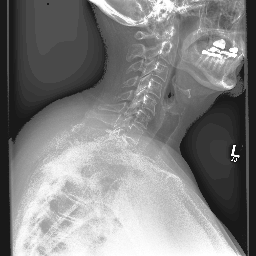

In [84]:
processed

In [113]:
root_folder =  os.path.join(DATA_ROOT, "processed/raw_corrected")
preprocessed_folder = os.path.join(DATA_ROOT, 'processed/preprocessed_corrected')

for folder in os.listdir(root_folder):
    # print(folder)
    if ".gitkeep" in folder or not os.path.isdir(folder):
        continue
    folder_path = os.path.join(root_folder, folder)
    assert(os.path.exists(folder_path))
    preprocessed_path = os.path.join(preprocessed_folder, folder)
    preprocess_dataset(root_folder,preprocessed_folder)

In [119]:
from skimage import exposure, img_as_float

In [130]:
im_eq = exposure.equalize_hist(npimg[:, :, 0])

<class 'numpy.ndarray'>


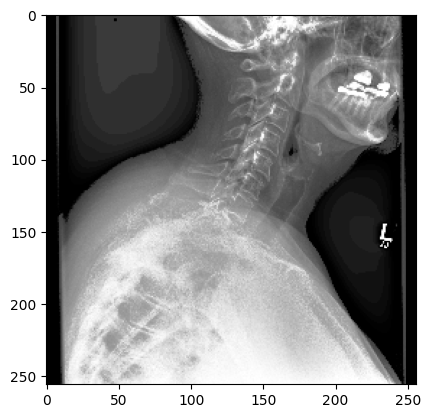

In [135]:
image = img_as_float(im_eq)
print(type(image))
plt.imshow(image, cmap=plt.cm.gray)